In [1]:
%matplotlib notebook

import pickle
import numpy as np
import matplotlib.pyplot as plt

from refnx.reflect import SLD, Slab, ReflectModel, MixedReflectModel
from refnx.dataset import ReflectDataset as RD
from refnx.analysis import Objective, CurveFitter, PDF, Parameter, process_chain, load_chain

from FreeformVFP import FreeformVFP

In [2]:
# Version numbers allow you to repeat the analysis on your computer and obtain identical results.
import refnx, scipy
refnx.__version__, np.version.version, scipy.version.version

('0.1.12.dev0+b27fb97', '1.15.4', '1.2.1')

# Load data
Three datasets are included, pNIPAM at 25 °C, 32.5 °C and 40 °C. 

pNIPAM is thermoresponsive; the 25 °C is a swollen, diffuse layer, whilst the 40 °C data is a collapsed slab.

In [24]:
data = RD("pNIPAM brush in d2o at 25C.dat")
# data = RD("pNIPAM brush in d2o at 32C.dat")
# data = RD("pNIPAM brush in d2o at 40C.dat")

# Define materials and slab components

For simplicity some parameters that may normally have been allowed to vary have been set to predetermined optimum values.

In [25]:
si      = SLD(2.07, 'si')
sio2    = SLD(2.9, 'sio2')
d2o     = SLD(6.23 , 'd2o')
polymer = SLD(0.81, 'polymer')

si_l          = si(0, 0)
sio2_l        = sio2(20, 4.8)

d2o_l         = d2o(0, 0)

# Create the freeform component

In [26]:
knot_num=4

#Polymer layer 1
polymer_0 = polymer(2, 0.5)


# Polymer-Solvent interface (spline)
polymer_vfp = FreeformVFP(adsorbed_amount=120,
                          vff=[0.6] * knot_num,
                          dzf=[1/(knot_num + 1)] * (knot_num+1),
                          polymer_sld=polymer, 
                          name='freeform vfp',
                          left_slabs=[polymer_0])

# Set paramerters bounds

In [27]:
sio2.real.setp                   (vary=True, bounds=(2.8, 3.47))

polymer_0.thick.setp             (vary=True, bounds=(2, 20))
polymer_0.vfsolv.setp            (vary=True, bounds=(0.1, 0.7))

polymer_vfp.adsorbed_amount.setp (vary=True, bounds=(100,130))


# We can enforce monotonicity through the bounds we place on the fractional volume fraction changes.
enforce_mono = True

if enforce_mono:
    bounds = (0.1,1)
else:
    bounds = (0.1,1.5)


# Here we set the bounds on the knot locations
for idx in range(knot_num):
    polymer_vfp.vff[idx].setp(vary=True, bounds=bounds)
    polymer_vfp.dzf[idx].setp (vary=True, bounds=(0.05, 1))

polymer_vfp.dzf[-1].setp (vary=True, bounds=(0.05, 1))

polymer_vfp.dzf[0].setp (vary=True, bounds=(0.005, 1))

# Create the structure, model, objective

In [28]:
structure =  si_l | sio2_l | polymer_0 | polymer_vfp | d2o_l

# contracting the slab representation reduces computation time.
structure.contract = 1.5

model = ReflectModel(structure)
model.bkg.setp(vary=True, bounds=(1e-6, 1e-5))
objective = Objective(model, data)

In [29]:
fitter= CurveFitter(objective)
fitter.fit('differential_evolution');

<IPython.core.display.Javascript object>


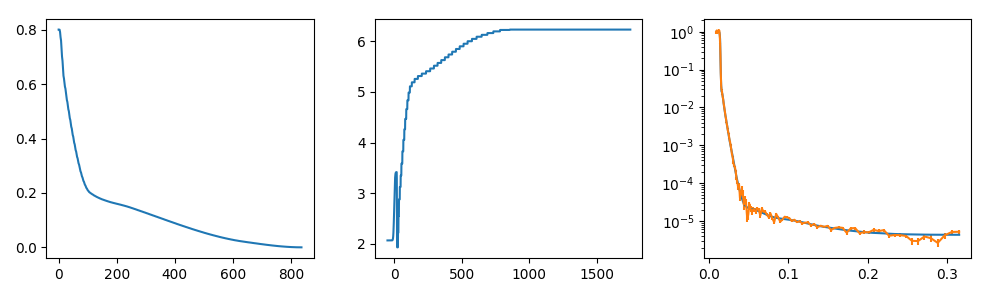

In [30]:
fig, [ax_vfp, ax_sld, ax_refl] = plt.subplots(1,3, figsize=(10,3), dpi=90)
z = np.linspace(-50,1750,2000)

ax_vfp.plot(*polymer_vfp.profile())
ax_sld.plot(*structure.sld_profile(z))
ax_refl.plot(data.x, objective.generative())
ax_refl.errorbar(data.x, data.y, yerr=data.y_err)

ax_refl.set_yscale('log')

fig.tight_layout()